In [3]:
# ruff: noqa: F401, E402, T201, T203, D103

from __future__ import annotations

import math
import sys
import time
from bisect import bisect_left, bisect_right
from collections import Counter, deque
from functools import cmp_to_key, lru_cache, reduce
from heapq import heapify, heappop, heappush, heappushpop, nsmallest
from importlib import reload
from itertools import (
    accumulate,
    chain,
    combinations,
    islice,
    pairwise,
    permutations,
    product,
    repeat,
    starmap,
    tee,
)
from math import comb, exp, factorial, inf, log, prod, sqrt
from operator import add, and_, contains, indexOf, itemgetter, mul, neg, or_, xor
from pprint import pformat, pprint
from typing import Callable, Iterable, Iterator, List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import HTML, clear_output, display

import arrays
import bits
import combinatorics
import graphs
import grid
import lists
import mathematics
import matrix
import parsing
import search
import sequences
import sets
import stack
import strings
import trees

for m in (
    arrays,
    bits,
    combinatorics,
    graphs,
    grid,
    lists,
    mathematics,
    matrix,
    parsing,
    search,
    sequences,
    sets,
    stack,
    strings,
    trees,
):
    reload(m)


from combinatorics import fib
from search import lower_index, upper_index
from sequences import find_if
from strings import splint

np.set_printoptions(linewidth=110)
print()

dtype('float128')

In [42]:
dd = np.longdouble

LOG2_GOLDEN_RATIO = np.log2(1.0 + np.sqrt(5.0, dtype=dd), dtype=dd) - 1.0
LOG2_SQRT5 = np.log2(5.0, dtype=dd) / 2.0


def fib_by_rounding(n: int) -> int:
    """Fibonacci number: `(fib(n-1) + fib(n-2))`."""
    if n == 0:
        return 1
    # Rounding formula. Works until n == 70.
    return round(np.power(2.0, LOG2_GOLDEN_RATIO * n - LOG2_SQRT5, dtype=np.longdouble))

In [82]:
diffs = []
for n in range(330):
    fr, f = fib_by_rounding(n) % (10**43 + 7), fib(n, 10**43 + 7)
    diffs.append(abs(f - fr) / f)

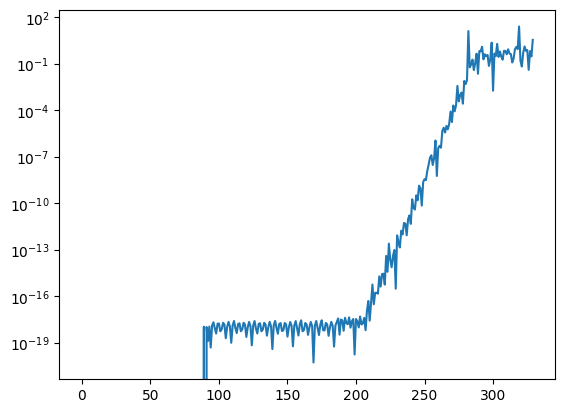

In [85]:
plt.yscale("log")
plt.plot(diffs)